# Callisto Test Generation for SVHN

### Dependencies
* Python 3
* Keras
* Tensorflow==1.15.0
* Random
* Pickle
* Math
* Matplotlib
* OpenCV
* SVHN Dataset
* h5py


In [3]:
from __future__ import absolute_import
from __future__ import print_function

import os
import cv2
import time
from datetime import timedelta
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,InputLayer
from keras.models import Model
import _pickle as pickle
import tensorflow as tf
import copy

Using TensorFlow backend.


#### Please change 'MINI_DATASET_TEST' to False if you want to run the full SVHN dataset. Once it is set to true, the test generation framework will only run for a subset images in the interest of time. 

In [4]:
MINI_DATASET_TEST = True
MINI_DATASET_N = 1000

#### Please change 'VERBOSE' to False if you want to not print a lot of information

In [5]:
VERBOSE = True

### Please download the SVHN data [here](https://drive.google.com/file/d/1Zxz1QC5ZD6eREwLfjv1NVdUaZxV0hp4U/view?usp=sharing) and save it in the "data" folder under SVHN

### You <span style="color:red">**need**</span> to download this file. It is not part of the github repo

### MD5 checksum = 2511787cf63e6d9d4495eafd120d701e

In [6]:
# Open the file as readonly
h5f = h5py.File('../data/SVHN_grey.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
x_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

if MINI_DATASET_TEST:
    x_train = h5f['X_train'][:MINI_DATASET_N]
    y_train = h5f['y_train'][:MINI_DATASET_N]
    x_test = h5f['X_test'][:MINI_DATASET_N]
    y_test = h5f['y_test'][:MINI_DATASET_N]
    x_val = h5f['X_val'][:MINI_DATASET_N]
    y_val = h5f['y_val'][:MINI_DATASET_N]

# Close this file
h5f.close()

print('Training set', x_train.shape, y_train.shape)
print('Validation set', x_val.shape, y_val.shape)
print('Test set', x_test.shape, y_test.shape)

Training set (1000, 32, 32, 1) (1000, 10)
Validation set (1000, 32, 32, 1) (1000, 10)
Test set (1000, 32, 32, 1) (1000, 10)


In [7]:
def reload_train(MINI_DATASET_TEST_FUNC, MINI_DATASET_N_FUNC):
    h5f = h5py.File('../data/SVHN_grey.h5', 'r')
    
    x_train_func = h5f['X_train'][:]
    y_train_func = h5f['y_train'][:]
    
    if MINI_DATASET_TEST_FUNC:
        x_train_func = h5f['X_train'][:MINI_DATASET_N_FUNC]
        y_train_func = h5f['y_train'][:MINI_DATASET_N_FUNC]
    h5f.close()
    
    return x_train_func, y_train_func

### Please download the pre-trained SVHN model [here](https://drive.google.com/file/d/1wAxCv0hpV-_i5GUTsWr8WcgshKAdSupA/view?usp=sharing) and save it in the "models" folder under SVHN.  

### If you have downloaded this file as part of the GitHub repo, it should be downloaded automatically

### MD5 checksum = 25537c56c03699796dcc940fecbceb12

In [1]:
model1_file = "../models/SVHN.h5py"

In [2]:
model1=Sequential()
model1.add(Conv2D(
        input_shape=[32, 32, 1],
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding="valid"))
model1.add(Conv2D(
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding="valid"))
model1.add(Conv2D(
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding="valid"))
model1.add(Flatten())
model1.add(Dense(10,activation="softmax",kernel_initializer='random_uniform',
                bias_initializer='zeros'))

NameError: name 'Sequential' is not defined

In [8]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model1.load_weights(model1_file)

In [10]:
layer_outputs = [layer.output for layer in model1.layers]

activation_model = Model(inputs=model1.input, outputs=layer_outputs)

In [11]:
test_loss, test_acc = model1.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

W1208 01:14:28.705978 4573683008 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



1000/1000 [==============================] - 0s 265us/step
Test accuracy: 0.8870000243186951


### all_train_acts.pickle contains all the activations of the training data. This is necesscary for Callisto to calculate the shannon indices of the image input. Please download the file [here](https://drive.google.com/file/d/1PGVjDtV-vJJHz9QEjkIUpWPMNaTbGQpd/view?usp=sharing). The file should be saved in the "saved_pickles" folder SVHN

### If you have downloaded this file as part of the GitHub repo, it should be downloaded automatically

### MD5 Sum = fad8fea2d32f180a9acf102968f96f3e

In [12]:
with open('../saved_pickles/all_train_acts.pickle', 'rb') as handle: 
     all_acts = pickle.load(handle)
        
if MINI_DATASET_TEST:
    all_acts = all_acts[:MINI_DATASET_N]


In [13]:
def shannon(arrs):
    shannons = []
    for arr in arrs:
        sum = 0
        for i in arr:
            sum += (i*np.log(i))
        shannons.append(sum * -1.0)
    return shannons

In [14]:
all_shannons = shannon(all_acts)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


In [15]:
low_shannon_true = []
for i in range(len(all_shannons)):
    if all_shannons[i] < 0.001 and np.argmax(all_acts[i]) == np.argmax(y_train[i]) : 
        low_shannon_true.append(i)
        
print("low_shannon_true:", len(low_shannon_true))

low_shannon_true: 523


In [16]:
rows,cols = (32, 32)
M = np.float32([[1,0,2],[0,1,2]])

Original Image


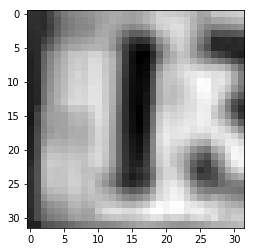

In [17]:
print("Original Image")
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
img = x_train[0]
label = y_train[0]
plt.imshow(img.reshape(32,32), cmap=plt.cm.binary)
plt.show()

Transformation: Panning


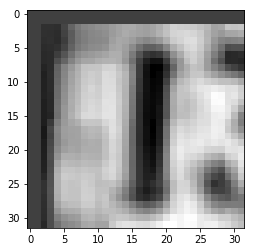

In [18]:
print("Transformation: Panning")
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
rows,cols = (32, 32)
M = np.float32([[1,0,2],[0,1,2]])
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [19]:
print("Transformation: Panning")
cols,rows = 32, 32
count_made_false_low_shannon_true = 0
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[7][0]
    
    dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[7][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1
        
if VERBOSE:
    print("Shannon Treshold : < 0.001")        
    print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Panning
Shannon Treshold : < 0.001
Number of inputs:  523
Error Rate:  0.028680688336520075


In [20]:
print("Transformation: Panning")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)

    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    if VERBOSE:
        print("Shannon Treshold : >", threshold)
        print("Number of inputs: ", len(high_shannon_true))


    count_made_false_high_shannon_true = 0
    for i in high_shannon_true:
        img = x_train[i]
        label = y_train[i]
        img = (np.expand_dims(img,0))
        img_pred = activation_model.predict(img)[7][0]

        dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,1)
        dst = (np.expand_dims(dst,0))
        dst_pred = activation_model.predict(dst)[7][0]
        if (np.argmax(img_pred) != np.argmax(dst_pred)):
            count_made_false_high_shannon_true += 1
            
    if VERBOSE:       
        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        print("")
    
    if not VERBOSE:
        print((count_made_false_high_shannon_true*1.0)/len(high_shannon_true))

    

Transformation: Panning
Shannon Treshold : > 0.01
Number of inputs:  310
Error Rates : 0.31290322580645163

Shannon Treshold : > 0.025
Number of inputs:  250
Error Rates : 0.36

Shannon Treshold : > 0.05
Number of inputs:  208
Error Rates : 0.375

Shannon Treshold : > 0.1
Number of inputs:  167
Error Rates : 0.38922155688622756

Shannon Treshold : > 0.2
Number of inputs:  118
Error Rates : 0.3983050847457627

Shannon Treshold : > 0.3
Number of inputs:  88
Error Rates : 0.42045454545454547

Shannon Treshold : > 0.4
Number of inputs:  76
Error Rates : 0.4342105263157895

Shannon Treshold : > 0.5
Number of inputs:  61
Error Rates : 0.45901639344262296

Shannon Treshold : > 0.6
Number of inputs:  51
Error Rates : 0.5098039215686274

Shannon Treshold : > 0.7
Number of inputs:  36
Error Rates : 0.4722222222222222

Shannon Treshold : > 0.8
Number of inputs:  28
Error Rates : 0.5

Shannon Treshold : > 0.9
Number of inputs:  25
Error Rates : 0.52

Shannon Treshold : > 1.0
Number of inputs:  19


Transformation: 2D rotation


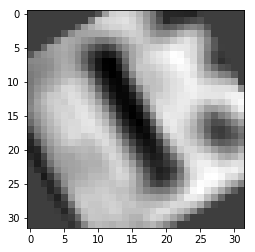

In [21]:
print("Transformation: 2D rotation")
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
rows,cols = (32, 32)
M = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [22]:
print("Transformation: 2D rotation")
cols,rows = 32, 32
count_made_false_low_shannon_true = 0
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[7][0]
    
    dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[7][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1

if VERBOSE:
    print("Shannon Treshold : < 0.001")        
    print("Number of inputs: ", len(low_shannon_true))
    
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: 2D rotation
Shannon Treshold : < 0.001
Number of inputs:  523
Error Rate:  0.4321223709369025


In [23]:
print("Transformation: 2D rotation")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)

    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)
    
    if VERBOSE:
        print("Shannon Treshold : >", threshold)
        print("Number of inputs: ", len(high_shannon_true))


    count_made_false_high_shannon_true = 0
    for i in high_shannon_true:
        img = x_train[i]
        label = y_train[i]
        img = (np.expand_dims(img,0))
        img_pred = activation_model.predict(img)[7][0]

        dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,1)
        dst = (np.expand_dims(dst,0))
        dst_pred = activation_model.predict(dst)[7][0]
        if (np.argmax(img_pred) != np.argmax(dst_pred)):
            count_made_false_high_shannon_true += 1
            
        
    if VERBOSE:       
        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        print("")
    
    if not VERBOSE:
        print((count_made_false_high_shannon_true*1.0)/len(high_shannon_true))

    

Transformation: 2D rotation
Shannon Treshold : > 0.01
Number of inputs:  310
Error Rates : 0.7322580645161291

Shannon Treshold : > 0.025
Number of inputs:  250
Error Rates : 0.76

Shannon Treshold : > 0.05
Number of inputs:  208
Error Rates : 0.7932692307692307

Shannon Treshold : > 0.1
Number of inputs:  167
Error Rates : 0.8143712574850299

Shannon Treshold : > 0.2
Number of inputs:  118
Error Rates : 0.8389830508474576

Shannon Treshold : > 0.3
Number of inputs:  88
Error Rates : 0.8636363636363636

Shannon Treshold : > 0.4
Number of inputs:  76
Error Rates : 0.881578947368421

Shannon Treshold : > 0.5
Number of inputs:  61
Error Rates : 0.8852459016393442

Shannon Treshold : > 0.6
Number of inputs:  51
Error Rates : 0.9215686274509803

Shannon Treshold : > 0.7
Number of inputs:  36
Error Rates : 0.9444444444444444

Shannon Treshold : > 0.8
Number of inputs:  28
Error Rates : 0.9642857142857143

Shannon Treshold : > 0.9
Number of inputs:  25
Error Rates : 0.96

Shannon Treshold : >

Transformation: Affine


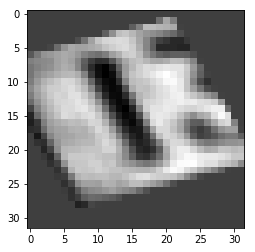

In [24]:
print("Transformation: Affine")
rows,cols = (32, 32)
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
pts1 = np.float32([[5,5],[28,5],[5,28]])
pts2 = np.float32([[1,10],[20,5],[10,25]])
M = cv2.getAffineTransform(pts1,pts2)
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [25]:
print("Transformation: Affine")
cols,rows = 32, 32
count_made_false_low_shannon_true = 0
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[7][0]
    
    dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[7][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1

if VERBOSE:
    print("Shannon Treshold : < 0.001")        
    print("Number of inputs: ", len(low_shannon_true))
    
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Affine
Shannon Treshold : < 0.001
Number of inputs:  523
Error Rate:  0.5793499043977055


In [26]:
print("Transformation: Affine")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)

    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)
    
    if VERBOSE:
        print("Shannon Treshold : >", threshold)
        print("Number of inputs: ", len(high_shannon_true))


    count_made_false_high_shannon_true = 0
    for i in high_shannon_true:
        img = x_train[i]
        label = y_train[i]
        img = (np.expand_dims(img,0))
        img_pred = activation_model.predict(img)[7][0]

        dst = cv2.warpAffine(x_train[i],M,(32,32)).reshape(32,32,1)
        dst = (np.expand_dims(dst,0))
        dst_pred = activation_model.predict(dst)[7][0]
        if (np.argmax(img_pred) != np.argmax(dst_pred)):
            count_made_false_high_shannon_true += 1
            
        
    if VERBOSE:       
        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        print("")
    
    if not VERBOSE:
        print((count_made_false_high_shannon_true*1.0)/len(high_shannon_true))

    

Transformation: Affine
Shannon Treshold : > 0.01
Number of inputs:  310
Error Rates : 0.7935483870967742

Shannon Treshold : > 0.025
Number of inputs:  250
Error Rates : 0.812

Shannon Treshold : > 0.05
Number of inputs:  208
Error Rates : 0.8221153846153846

Shannon Treshold : > 0.1
Number of inputs:  167
Error Rates : 0.8263473053892215

Shannon Treshold : > 0.2
Number of inputs:  118
Error Rates : 0.8389830508474576

Shannon Treshold : > 0.3
Number of inputs:  88
Error Rates : 0.8409090909090909

Shannon Treshold : > 0.4
Number of inputs:  76
Error Rates : 0.8289473684210527

Shannon Treshold : > 0.5
Number of inputs:  61
Error Rates : 0.8688524590163934

Shannon Treshold : > 0.6
Number of inputs:  51
Error Rates : 0.8627450980392157

Shannon Treshold : > 0.7
Number of inputs:  36
Error Rates : 0.8888888888888888

Shannon Treshold : > 0.8
Number of inputs:  28
Error Rates : 0.9285714285714286

Shannon Treshold : > 0.9
Number of inputs:  25
Error Rates : 0.92

Shannon Treshold : > 1.

Transformation: Perspective


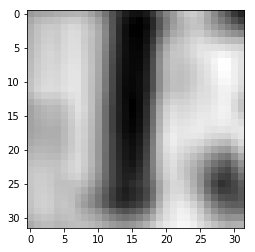

In [27]:
print("Transformation: Perspective")
rows,cols = (32, 32)
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
pts1 = np.float32([[5,5],[28,5],[5,28],[28,28]])
pts2 = np.float32([[0,0],[32,0],[0,32],[32,32]])
M = cv2.getPerspectiveTransform(pts1,pts2)
img = x_train[0]
dst = cv2.warpPerspective(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [28]:
print("Transformation: Perspective")
cols,rows = 32, 32
count_made_false_low_shannon_true = 0
x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[7][0]
    
    dst = cv2.warpPerspective(x_train[i],M,(32,32)).reshape(32,32,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[7][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1

if VERBOSE:
    print("Shannon Treshold : < 0.001")        
    print("Number of inputs: ", len(low_shannon_true))
    
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Perspective
Shannon Treshold : < 0.001
Number of inputs:  523
Error Rate:  0.13193116634799235


In [29]:
print("Transformation: Perspective")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    x_train, y_train = reload_train(MINI_DATASET_TEST, MINI_DATASET_N)

    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)
    
    if VERBOSE:
        print("Shannon Treshold : >", threshold)
        print("Number of inputs: ", len(high_shannon_true))


    count_made_false_high_shannon_true = 0
    for i in high_shannon_true:
        img = x_train[i]
        label = y_train[i]
        img = (np.expand_dims(img,0))
        img_pred = activation_model.predict(img)[7][0]

        dst = cv2.warpPerspective(x_train[i],M,(32,32)).reshape(32,32,1)
        dst = (np.expand_dims(dst,0))
        dst_pred = activation_model.predict(dst)[7][0]
        if (np.argmax(img_pred) != np.argmax(dst_pred)):
            count_made_false_high_shannon_true += 1
            
        
    if VERBOSE:       
        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        print("")
    
    if not VERBOSE:
        print((count_made_false_high_shannon_true*1.0)/len(high_shannon_true))

    

Transformation: Perspective
Shannon Treshold : > 0.01
Number of inputs:  310
Error Rates : 0.3741935483870968

Shannon Treshold : > 0.025
Number of inputs:  250
Error Rates : 0.408

Shannon Treshold : > 0.05
Number of inputs:  208
Error Rates : 0.44711538461538464

Shannon Treshold : > 0.1
Number of inputs:  167
Error Rates : 0.4491017964071856

Shannon Treshold : > 0.2
Number of inputs:  118
Error Rates : 0.5254237288135594

Shannon Treshold : > 0.3
Number of inputs:  88
Error Rates : 0.6022727272727273

Shannon Treshold : > 0.4
Number of inputs:  76
Error Rates : 0.5921052631578947

Shannon Treshold : > 0.5
Number of inputs:  61
Error Rates : 0.639344262295082

Shannon Treshold : > 0.6
Number of inputs:  51
Error Rates : 0.7254901960784313

Shannon Treshold : > 0.7
Number of inputs:  36
Error Rates : 0.6944444444444444

Shannon Treshold : > 0.8
Number of inputs:  28
Error Rates : 0.6428571428571429

Shannon Treshold : > 0.9
Number of inputs:  25
Error Rates : 0.64

Shannon Treshold :